# End-to-End Training Pipeline

In [1]:
import os
import gc
import utils
import pyarrow

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

from joblib import parallel_backend

In [2]:
import seaborn as sns; sns.set()

In [3]:
# client = Client()
pbar = ProgressBar()
pbar.register()

In [4]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, 'D')
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, 'D')

## Data Ingestion

In [5]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [6]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
DATA_ROOT_DIR = '/home/kachauha/Downloads/'
df4 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q4_2018_parquet'), engine='pyarrow', index=False)
df3 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q3_2018_parquet'), engine='pyarrow', index=False)
df = dd.concat(dfs=[df3, df4], interleave_partitions=True)
# df = dd.read_csv(
#     "s3://DH-PLAYPEN/kachauha/*/*.csv",
#     storage_options={
#         "client_kwargs": {"endpoint_url": "https://s3.upshift.redhat.com/"}
#     },
#     dtype=custom_dtypes
# )
seagate_df = utils.optimal_repartition_df(df[df['model'].str.startswith('S')])

[########################################] | 100% Completed | 53.0s


In [7]:
# convert from str to datetime
seagate_df['date'] = seagate_df['date'].astype('datetime64')

In [8]:
# get failed serial numbers
failed_sers = seagate_df[seagate_df['failure']==1]['serial_number'].compute()
failed_sers.head()

[########################################] | 100% Completed | 35.8s


8963     ZA12624Y
70357    S300Z4Y3
4285     Z300K1Z7
99943    W300L6AL
4487     Z3025LEN
Name: serial_number, dtype: object

## Feature Selection

In [9]:
# start off with critical columns as indicated from 3 sources
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

In [10]:
print('Seagate')
seagate_nan_ct = utils.get_nan_count_percent(seagate_df[crit_cols_raw + crit_cols_normalized])
seagate_nan_ct.compute()

Seagate
[########################################] | 100% Completed | 37.1s
[########################################] | 100% Completed | 35.9s


,count,percent
smart_1_raw,367,0.000026
smart_5_raw,867,0.000061
smart_7_raw,867,0.000061
smart_10_raw,867,0.000061
smart_184_raw,4783905,0.334475
smart_187_raw,112942,0.007897
smart_188_raw,112942,0.007897
smart_189_raw,4783905,0.334475
smart_190_raw,112942,0.007897
smart_193_raw,114007,0.007971


In [7]:
seagate_corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
seagate_corr['failure'].abs().sort_values(ascending=False)

[########################################] | 100% Completed |  5min 30.4s


failure                 1.000000
smart_197_raw           0.071970
smart_198_raw           0.071965
smart_187_normalized    0.048009
smart_187_raw           0.045364
smart_5_raw             0.033866
smart_7_raw             0.015851
smart_184_normalized    0.006764
smart_184_raw           0.006764
smart_10_normalized     0.001883
smart_188_raw           0.001669
smart_5_normalized      0.001531
smart_198_normalized    0.001486
capacity_bytes          0.001405
smart_193_normalized    0.001357
smart_241_raw           0.001145
smart_193_raw           0.001085
smart_194_raw           0.001052
smart_190_normalized    0.001031
smart_190_raw           0.001031
smart_7_normalized      0.000905
smart_197_normalized    0.000782
smart_1_normalized      0.000742
smart_242_raw           0.000425
smart_1_raw             0.000264
smart_189_normalized    0.000213
smart_194_normalized    0.000093
smart_189_raw           0.000044
smart_240_raw           0.000002
smart_10_raw                 NaN
smart_196_

In [8]:
# re-selection of critical columns based on number of nans and correlations
CRITICAL_STATS = [1, 5, 7, 10, 187, 188, 190, 193, 194, 197, 198, 240, 241, 242]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

In [9]:
seagate_corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
seagate_corr['failure'].abs().sort_values(ascending=False)

[########################################] | 100% Completed |  4min  2.5s


failure                 1.000000
smart_197_raw           0.071970
smart_198_raw           0.071965
smart_187_normalized    0.048009
smart_187_raw           0.045364
smart_5_raw             0.033866
smart_7_raw             0.015851
smart_10_normalized     0.001883
smart_188_raw           0.001669
smart_5_normalized      0.001531
smart_198_normalized    0.001486
capacity_bytes          0.001405
smart_193_normalized    0.001357
smart_241_raw           0.001145
smart_193_raw           0.001085
smart_194_raw           0.001052
smart_190_normalized    0.001031
smart_190_raw           0.001031
smart_7_normalized      0.000905
smart_197_normalized    0.000782
smart_1_normalized      0.000742
smart_242_raw           0.000425
smart_1_raw             0.000264
smart_194_normalized    0.000093
smart_240_raw           0.000002
smart_10_raw                 NaN
smart_188_normalized         NaN
smart_240_normalized         NaN
smart_241_normalized         NaN
smart_242_normalized         NaN
Name: fail

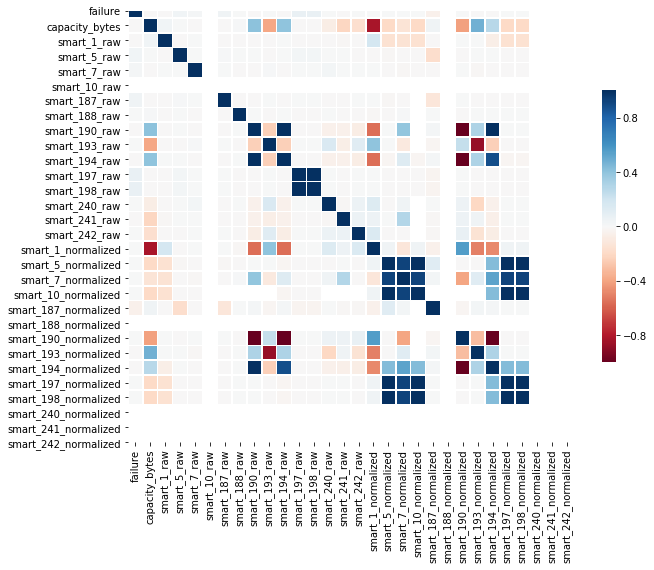

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seagate_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [16]:
seagate_corr['smart_5_normalized']['smart_198_normalized']

0.9999071374115623

**NOTES**
1. 190 is temperature, and 194 is temperature difference, i.e. almost completely correlated. Therefore we can remove one. Removing 194 is better because it is more correlated to some other features (smart_5_normalized) than 190 is.
2. Normalized 5, 7, 10, 197, 198 are highly correlated

In [17]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [23]:
# make sure we remove nans - sklearn doesnt deal well with those
test_df = seagate_df[['failure', 'smart_5_normalized', 'smart_7_normalized', 'smart_10_normalized', 'smart_197_normalized', 'smart_198_normalized']].dropna()
test_df.isna().any().any().compute()

False

In [24]:
# split
test_X = test_df.drop('failure', axis=1)
test_y = test_df['failure']

In [25]:
with parallel_backend('dask'):
    # inspect deeper into highly correlated features
    print(chi2(test_X, test_y))

(array([59.49062003, 32.70783332, 90.00985241, 15.44540977, 56.06036256]), array([1.22878412e-14, 1.07104718e-08, 2.36976979e-21, 8.49229521e-05,
       7.02798072e-14]))


In [27]:
# want big values
with parallel_backend('dask'):
    # inspect deeper into highly correlated features
    print(f_classif(test_X, test_y))

(array([-24.14215255,  40.03846428, -14.97191752, -28.241386  ,
       -23.04656271]), array([           nan, 2.49018252e-10,            nan,            nan,
                  nan]))


In [9]:
# for now, keep the highly correlated ones but remove 194. remove 240, 242 as well (too low corr)
CRITICAL_STATS = [1, 5, 7, 10, 187, 188, 190, 193, 197, 198, 241]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]
seagate_df = seagate_df[['date', 'serial_number', 'model', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized]

## Handle Missing Values

In [12]:
# what is the nan situation like
utils.get_nan_count_percent(seagate_df).compute()

[########################################] | 100% Completed | 36.7s
[########################################] | 100% Completed | 37.8s


,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,367,0.000026
smart_5_raw,867,0.000061
smart_7_raw,867,0.000061
smart_10_raw,867,0.000061
smart_187_raw,112942,0.007897


In [19]:
# failed drives that have nan values
failed_df = seagate_df[seagate_df['serial_number'].isin(failed_sers)]
utils.get_nan_count_percent(failed_df).compute()

,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,2,0.000088
smart_5_raw,2,0.000088
smart_7_raw,2,0.000088
smart_10_raw,2,0.000088
smart_187_raw,2,0.000088


In [20]:
# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = seagate_df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
seagate_df = seagate_df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [ ]:
len_failed_df = len(failed_df)

In [40]:
# how many drives had nan values close to fail day
utils.get_nan_count_percent(failed_df[failed_df['rul_days']<=BAD_THRESHOLD_NDAYS], divisor=len_failed_df).compute()

,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,2,0.000035
smart_5_raw,2,0.000035
smart_7_raw,2,0.000035
smart_10_raw,2,0.000035
smart_187_raw,300,0.005243


In [41]:
# how many drives had nan values exactly on fail day
utils.get_nan_count_percent(failed_df[failed_df['failure']==1], divisor=len_failed_df).compute()

,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,0,0.000000
smart_5_raw,0,0.000000
smart_7_raw,0,0.000000
smart_10_raw,0,0.000000
smart_187_raw,21,0.000367


In [10]:
# drop the nans that occur in working hard drives, keep the ones in failing ones for now
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers))\
                       | ((~seagate_df['smart_1_raw'].isna())\
                       & (~seagate_df['smart_5_raw'].isna())\
                       & (~seagate_df['smart_187_raw'].isna())\
                       & (~seagate_df['smart_193_raw'].isna())\
                       & (~seagate_df['smart_241_raw'].isna()))]

# shouldnt have any nan values from working drives now
utils.get_nan_count_percent(seagate_df).compute()

[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 41.1s


,count,percent
date,0,0.000000e+00
serial_number,0,0.000000e+00
model,0,0.000000e+00
capacity_bytes,0,0.000000e+00
failure,0,0.000000e+00
smart_1_raw,3,2.114359e-07
smart_5_raw,3,2.114359e-07
smart_7_raw,3,2.114359e-07
smart_10_raw,3,2.114359e-07
smart_187_raw,1951,1.375038e-04


In [11]:
# how many points will we lose if we just drop nans for failed ones
seagate_df = seagate_df[(~seagate_df['smart_1_raw'].isna())\
#                        & (~seagate_df['smart_5_raw'].isna())\
#                        & (~seagate_df['smart_187_raw'].isna())\
#                        & (~seagate_df['smart_193_raw'].isna())\
                       & (~seagate_df['smart_241_raw'].isna())]

utils.get_nan_count_percent(seagate_df).compute()

## Prepare + Preprocess

### Add RUL, Class labels

In [13]:
# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = seagate_df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
seagate_df = seagate_df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [14]:
# remove working drive data that is recorded after [quarter end minus 6 weeks]
# because we dont know (as of quarter end) if those drives survived more than 6 weeks or not
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers)) | (seagate_df['rul_days'] >= WARNING_THRESHOLD_NDAYS)]
# print(dd.compute(seagate_df.shape))

In [15]:
# NOTE: assignment must be done in th
# df.head()is order otherwise it wont be correct. FIXME
# assign all as good initially
seagate_df['status'] = 0

# overwrite those which have rul less than 6 weeks as warning
seagate_df['status'] = seagate_df['status'].mask(seagate_df['rul_days'] < WARNING_THRESHOLD_NDAYS, 1)

# overwrite those which have rul less than 2 weeks as bad
seagate_df['status'] = seagate_df['status'].mask(seagate_df['rul_days'] < BAD_THRESHOLD_NDAYS, 2)

In [16]:
seagate_df = utils.optimal_repartition_df(seagate_df)

[########################################] | 100% Completed |  5min  3.2s


### OPTION 1: Downsample

In [18]:
num_working_serials = 7500
working_sers = seagate_df[~seagate_df['serial_number'].isin(failed_sers)]['serial_number'].unique()
working_repr_sers = working_sers.sample(frac=(num_working_serials/len(working_sers))).compute()

[########################################] | 100% Completed |  4min  2.0s
[########################################] | 100% Completed |  4min  1.5s


In [21]:
# preprocess only downsampled data
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers)) | seagate_df['serial_number'].isin(working_repr_sers)]

### OPTION 2: Within category features (mean,std)

See tsfresh for more. Add std, mean daily change (is this significantly diff than std conceptually?), sum of changes, c3 (Discrimination power of measures for nonlinearity in a time series), fft_aggreagated (spectral centroid seems more promising), large std (is it > c x maxx-minx), 
**TODO** How would inference work? Should we do it by 6 day intervals instead??

In [16]:
# aggregate by category
seagate_feats_df = utils.featurize_ts(seagate_df,
                                 drop_cols=['date', 'model', 'capacity_bytes', 'failure', 'rul_days'],
                                 group_cols=['serial_number', 'status'])

seagate_feats_df = seagate_feats_df.reset_index()
seagate_feats_df.head()

[########################################] | 100% Completed |  4min 15.6s


,serial_number,status,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_7_normalized,std_smart_10_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_241_normalized,capacity_bytes
0,S300CWX4,0,1.199181e+08,0.0,2.667180e+08,0.0,0.0,0.0,20.709220,8285.340426,...,1.310542,0.0,0.0,0.0,1.007342,0.000000,0.0,0.0,0.0,4.000787e+12
1,S300F3D4,0,1.131556e+08,0.0,9.401279e+08,0.0,0.0,0.0,20.645390,125850.581560,...,0.495643,0.0,0.0,0.0,1.316229,8.867810,0.0,0.0,0.0,4.000787e+12
2,S300WCSR,0,1.237400e+08,0.0,3.489868e+08,0.0,0.0,0.0,25.517730,35898.609929,...,0.785667,0.0,0.0,0.0,1.049262,0.007092,0.0,0.0,0.0,4.000787e+12
3,S300WDGX,0,1.288554e+08,0.0,3.613633e+08,0.0,0.0,0.0,20.056738,35272.382979,...,0.806891,0.0,0.0,0.0,1.207383,0.007092,0.0,0.0,0.0,4.000787e+12
4,S300WEY6,0,1.143352e+08,0.0,3.068497e+08,0.0,0.0,0.0,25.746479,45188.746479,...,0.558518,0.0,0.0,0.0,1.567435,0.000000,0.0,0.0,0.0,4.000787e+12


In [34]:
# make sure agg is correct, and no data loss/corruptoin
seagate_feats_df[seagate_feats_df['serial_number']=='Z3025L7N'].head()

,serial_number,status,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_7_normalized,std_smart_10_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_241_normalized,capacity_bytes
101,Z3025L7N,1,1.948226e+08,0.0,1.554303e+08,0.0,0.0,0.0,19.153846,101057.0,...,0.0,0.0,0.0,0.0,0.360801,0.0,0.0,0.0,0.0,4.000787e+12
102,Z3025L7N,2,1.286402e+08,0.0,1.634259e+08,0.0,0.0,0.0,19.285714,101057.0,...,0.0,0.0,0.0,0.0,0.451754,0.0,0.0,0.0,0.0,4.000787e+12


In [17]:
seagate_df = utils.optimal_repartition_df(seagate_df)
dd.compute(seagate_feats_df.shape)

[########################################] | 100% Completed |  4min 16.7s
[########################################] | 100% Completed |  4min 27.8s


((82165, 47),)

In [28]:
corr = seagate_feats_df.corr().compute()
corr

,status,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,mean_smart_197_raw,...,std_smart_7_normalized,std_smart_10_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_241_normalized,capacity_bytes
status,1.000000,0.028828,0.085198,0.055129,NaN,0.296890,0.002615,0.012946,0.013798,0.077329,...,-0.088781,NaN,0.302705,NaN,-0.142659,-0.021538,0.134625,0.134625,NaN,NaN
mean_smart_1_raw,0.028828,1.000000,-0.004732,0.003253,NaN,-0.001183,0.003022,0.006673,0.008932,-0.012367,...,-0.000806,NaN,0.006469,NaN,0.002517,0.001962,0.002938,0.002938,NaN,NaN
mean_smart_5_raw,0.085198,-0.004732,1.000000,0.004200,NaN,0.030768,-0.001696,0.002595,-0.000523,0.516273,...,-0.011129,NaN,0.014010,NaN,-0.019758,-0.005211,0.025649,0.025649,NaN,NaN
mean_smart_7_raw,0.055129,0.003253,0.004200,1.000000,NaN,0.000158,-0.000552,-0.003254,-0.002290,-0.000072,...,0.041390,NaN,-0.000393,NaN,-0.015158,-0.001010,-0.000137,-0.000137,NaN,NaN
mean_smart_10_raw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_smart_187_raw,0.296890,-0.001183,0.030768,0.000158,NaN,1.000000,0.004232,0.031159,0.003687,0.006337,...,-0.025558,NaN,0.397177,NaN,-0.046545,0.021048,0.016776,0.016776,NaN,NaN
mean_smart_188_raw,0.002615,0.003022,-0.001696,-0.000552,NaN,0.004232,1.000000,0.031569,0.058691,0.000312,...,-0.012768,NaN,0.002242,NaN,0.011326,0.034511,0.005913,0.005913,NaN,NaN
mean_smart_190_raw,0.012946,0.006673,0.002595,-0.003254,NaN,0.031159,0.031569,1.000000,-0.033866,0.017150,...,0.171629,NaN,0.015613,NaN,0.162517,-0.005915,0.004534,0.004534,NaN,NaN
mean_smart_193_raw,0.013798,0.008932,-0.000523,-0.002290,NaN,0.003687,0.058691,-0.033866,1.000000,0.007540,...,-0.148232,NaN,0.011605,NaN,0.011294,0.143666,0.024302,0.024302,NaN,NaN
mean_smart_197_raw,0.077329,-0.012367,0.516273,-0.000072,NaN,0.006337,0.000312,0.017150,0.007540,1.000000,...,-0.007381,NaN,0.008900,NaN,-0.015869,-0.001916,0.126571,0.126571,NaN,NaN


### Stratified, Drive-wise Train/Test Split

In [19]:
# ['date', 'serial_number', 'model', 'failure', 'rul_days', 'status']
X_arr = seagate_feats_df.drop(['serial_number', 'status'], axis=1)
Y_arr = seagate_feats_df[['serial_number', 'status']]

In [20]:
X_arr = X_arr.compute()
Y_arr = Y_arr.compute()

[########################################] | 100% Completed |  4min 14.3s
[########################################] | 100% Completed |  4min  6.1s


In [21]:
X_arr = X_arr.reset_index(drop=True)
Y_arr = Y_arr.reset_index(drop=True)

In [22]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from dask_ml.preprocessing import RobustScaler as ddRobustScaler
from dask_ml.preprocessing import StandardScaler as ddStandardScaler
from dask_ml.model_selection import train_test_split as ddtrain_test_split

In [26]:
# split by serial number
failed_sers_red = pd.Series(Y_arr['serial_number'].unique())
failed_sers_red = failed_sers_red[failed_sers_red.isin(failed_sers)]

In [33]:
working_repr_sers = pd.Series(Y_arr['serial_number'].unique())
working_repr_sers = working_repr_sers[~working_repr_sers.isin(failed_sers)]

In [34]:
# split working and failed
working_train, working_test = train_test_split(working_repr_sers, test_size=0.2, random_state=42)
failed_train, failed_test = train_test_split(failed_sers_red, test_size=0.2, random_state=42)

In [35]:
# use serial numbers to generate train/test set
# CHECKED OK - train/test ratio 0.8, fail/work and overall both
X_train_work = X_arr[Y_arr['serial_number'].isin(working_train)]
X_train_fail = X_arr[Y_arr['serial_number'].isin(failed_train)]
X_train = pd.concat([X_train_work, X_train_fail])

Y_train_work = Y_arr[Y_arr['serial_number'].isin(working_train)]['status']
Y_train_fail = Y_arr[Y_arr['serial_number'].isin(failed_train)]['status']
Y_train = pd.concat([Y_train_work, Y_train_fail])

X_test_work = X_arr[Y_arr['serial_number'].isin(working_test)]
X_test_fail = X_arr[Y_arr['serial_number'].isin(failed_test)]
X_test = pd.concat([X_test_work, X_test_fail])

Y_test_work = Y_arr[Y_arr['serial_number'].isin(working_test)]['status']
Y_test_fail = Y_arr[Y_arr['serial_number'].isin(failed_test)]['status']
Y_test = pd.concat([Y_test_work, Y_test_fail])

### OPTION 1: Keep Xtest as is (summarized within category)

### OPTION 2: Create Xtest by rolling values

In [1]:
def test_rolling(df, window=6, drop_cols=('date', 'failure', 'capacity_bytes', 'rul'), group_cols=('serial_number'), cap=True, num_days=False):
    # group by serials, drop cols which are not to be aggregated
    if drop_cols is not None:
        grouped_df = df.drop(drop_cols, axis=1).groupby(group_cols)
    else:
        grouped_df = df.groupby(group_cols)

    # rolling window mean. drop the group_cols since they dont vary in a group
    # .drop(group_cols, axis=1)
    means = grouped_df.rolling(window)[[col for col in grouped_df.first().columns if col not in group_cols]].mean()
    means = means.rename(columns={col: 'mean_' + col for col in means.columns})
    
    # rolling window srd. drop the group_cols since they dont vary in a group
    stds = grouped_df.rolling(window)[[col for col in grouped_df.first().columns if col not in group_cols]].std(ddof=0)
    stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})

    # combine features into one df
    feats = means.merge(stds, left_index=True, right_index=True)
    
    # capacity of hard drive
    if cap:
        capacities = df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()
        feats = feats.merge(capacities, left_index=True, right_index=True)
    
    # number of days of observed data available
    if num_days:
        days_per_drive = grouped_df.size().to_frame('num_days')
        feats = feats.merge(days_per_drive, left_index=True, right_index=True)

    return feats

In [ ]:
X_test_arr = seagate_df[(seagate_df['serial_number'].isin(working_test)) | seagate_df['serial_number'].isin(failed_test)].compute()

In [59]:
X_test_rolling = test_rolling(X_test_arr,
                                 drop_cols=['date', 'model', 'capacity_bytes', 'failure', 'rul_days'],
                                 group_cols=['serial_number', 'status'])
X_test_rolling = X_test_rolling.reset_index(level=[0, 1]).dropna()
X_test_rolling.head()

,serial_number,status,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_7_normalized,std_smart_10_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_241_normalized,capacity_bytes
5,S3003TK3,0,1.671328e+08,0.0,3.057440e+08,0.0,0.0,0.0,25.166667,48684.666667,...,0.0,0.0,0.0,0.0,0.372678,0.0,0.0,0.0,0.0,4.000787e+12
6,S3003TK3,0,1.497556e+08,0.0,3.065060e+08,0.0,0.0,0.0,25.000000,48686.166667,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.000787e+12
7,S3003TK3,0,1.840393e+08,0.0,3.072345e+08,0.0,0.0,0.0,25.000000,48687.666667,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.000787e+12
8,S3003TK3,0,1.657880e+08,0.0,3.090353e+08,0.0,0.0,0.0,25.000000,48695.166667,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.000787e+12
9,S3003TK3,0,1.561300e+08,0.0,3.100337e+08,0.0,0.0,0.0,25.166667,48701.166667,...,0.0,0.0,0.0,0.0,0.372678,0.0,0.0,0.0,0.0,4.000787e+12


In [73]:
# split into x and y
X_test = X_test_rolling.drop(['serial_number', 'status'], axis=1)
Y_test = X_test_rolling['status']

### OPTION 3: Create Xtest by expanding values

In [80]:
def test_expanding(df, drop_cols=('date', 'failure', 'capacity_bytes', 'rul'), group_cols=('serial_number'), cap=True, num_days=False):
    # group by serials, drop cols which are not to be aggregated
    if drop_cols is not None:
        grouped_df = df.drop(drop_cols, axis=1).groupby(group_cols)
    else:
        grouped_df = df.groupby(group_cols)

    # rolling window mean. drop the group_cols since they dont vary in a group
    # .drop(group_cols, axis=1)
    means = grouped_df.expanding()[[col for col in grouped_df.first().columns if col not in group_cols]].mean()
    means = means.rename(columns={col: 'mean_' + col for col in means.columns})
    
    # rolling window srd. drop the group_cols since they dont vary in a group
    stds = grouped_df.expanding()[[col for col in grouped_df.first().columns if col not in group_cols]].std(ddof=0)
    stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})

    # combine features into one df
    feats = means.merge(stds, left_index=True, right_index=True)
    
    # capacity of hard drive
    if cap:
        capacities = df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()
        feats = feats.merge(capacities, left_index=True, right_index=True)
    
    # number of days of observed data available
    if num_days:
        days_per_drive = grouped_df.size().to_frame('num_days')
        feats = feats.merge(days_per_drive, left_index=True, right_index=True)

    return feats

In [81]:
X_test_expanding = test_expanding(X_test_arr,
                                 drop_cols=['date', 'model', 'capacity_bytes', 'failure', 'rul_days'],
                                 group_cols=['serial_number', 'status'])
X_test_expanding = X_test_expanding.reset_index(level=[0, 1]).dropna()
X_test_expanding.head()

,serial_number,status,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_7_normalized,std_smart_10_normalized,std_smart_187_normalized,std_smart_188_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_241_normalized,capacity_bytes
0,S3003TK3,0,216140736.0,0.0,2.998010e+08,0.0,0.0,0.0,26.000000,48680.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.000787e+12
1,S3003TK3,0,127196060.0,0.0,3.007490e+08,0.0,0.0,0.0,25.500000,48680.00,...,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,4.000787e+12
2,S3003TK3,0,124366568.0,0.0,3.014284e+08,0.0,0.0,0.0,25.333333,48680.00,...,0.0,0.0,0.0,0.0,0.471405,0.0,0.0,0.0,0.0,4.000787e+12
3,S3003TK3,0,143548502.0,0.0,3.031482e+08,0.0,0.0,0.0,25.250000,48682.25,...,0.0,0.0,0.0,0.0,0.433013,0.0,0.0,0.0,0.0,4.000787e+12
4,S3003TK3,0,157816312.0,0.0,3.043726e+08,0.0,0.0,0.0,25.200000,48683.60,...,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,4.000787e+12


In [82]:
X_test = X_test_expanding.drop(['serial_number', 'status'], axis=1)
Y_test = X_test_expanding['status']

### Scale

In [44]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [83]:
# trecolumnsas regular dataset and scale
# with parallel_backend('dask'):
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Train

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

### Vanilla Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [84]:
# with joblib.parallel_backend('dask'):
dt_clf = DecisionTreeClassifier(class_weight='balanced')
dt_clf.fit(X_train_scaled, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [85]:
# EXPANDING
# with joblib.parallel_backend('dask'):
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(np.around(dt_confmat, decimals=2))
print(classification_report(Y_test, dt_preds, target_names=['good', 'warning', 'bad']))

[[1757750  234433  154670]
 [    842     928     958]
 [    392     310     917]]
              precision    recall  f1-score   support

        good       1.00      0.82      0.90   2146853
     warning       0.00      0.34      0.01      2728
         bad       0.01      0.57      0.01      1619

    accuracy                           0.82   2151200
   macro avg       0.34      0.58      0.31   2151200
weighted avg       1.00      0.82      0.90   2151200



In [75]:
# ROLLING 6 DAYS
# with joblib.parallel_backend('dask'):
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(np.around(dt_confmat, decimals=2))
print(classification_report(Y_test, dt_preds, target_names=['good', 'warning', 'bad']))

[[ 520173  396355 1149486]
 [    578     522    1095]
 [    225     194     591]]
              precision    recall  f1-score   support

        good       1.00      0.25      0.40   2066014
     warning       0.00      0.24      0.00      2195
         bad       0.00      0.59      0.00      1010

    accuracy                           0.25   2069219
   macro avg       0.33      0.36      0.14   2069219
weighted avg       1.00      0.25      0.40   2069219



In [49]:
# regular
# with joblib.parallel_backend('dask'):
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(np.around(dt_confmat, decimals=2))
print(classification_report(Y_test, dt_preds, target_names=['good', 'warning', 'bad']))

[[16158    22    13]
 [   29    72     8]
 [   28     5    92]]
              precision    recall  f1-score   support

        good       1.00      1.00      1.00     16193
     warning       0.73      0.66      0.69       109
         bad       0.81      0.74      0.77       125

    accuracy                           0.99     16427
   macro avg       0.85      0.80      0.82     16427
weighted avg       0.99      0.99      0.99     16427



### Vanilla Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
rf_clf = RandomForestClassifier(n_estimators=128, class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train_scaled, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=128, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [118]:
# get preds
rf_preds = rf_clf.predict(scaler.transform(X_test))
rf_confmat = confusion_matrix(Y_test, rf_preds)

print(np.around(rf_confmat, decimals=2))
print(classification_report(Y_test, rf_preds, target_names=['good', 'warning', 'bad']))

[[137556    107   1314]
 [  2292     43    393]
 [  1128     46    445]]
              precision    recall  f1-score   support

        good       0.98      0.99      0.98    138977
     warning       0.22      0.02      0.03      2728
         bad       0.21      0.27      0.24      1619

    accuracy                           0.96    143324
   macro avg       0.47      0.43      0.42    143324
weighted avg       0.95      0.96      0.96    143324



## RGF

In [28]:
from rgf.sklearn import RGFClassifier

In [31]:
rgf_clf = RGFClassifier(max_leaf=2500, l2=1e-10, learning_rate=0.01)
rgf_clf.fit(X_train, Y_train)

RGFClassifier(algorithm='RGF', calc_prob='sigmoid', init_model=None, l2=1e-10,
              learning_rate=0.01, loss='Log', max_leaf=2500,
              memory_policy='generous', min_samples_leaf=10, n_iter=None,
              n_jobs=-1, n_tree_search=1, normalize=False, opt_interval=100,
              reg_depth=1.0, sl2=None, test_interval=100, verbose=0)

In [32]:
# get preds
rgf_preds = rgf_clf.predict(scaler.transform(X_test))
rgf_confmat = confusion_matrix(Y_test, rgf_preds)

print(np.around(rgf_confmat / rgf_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, rgf_preds, target_names=['good', 'warning', 'bad']))

[[1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.98 0.   0.02]]
              precision    recall  f1-score   support

        good       0.99      1.00      0.99     16197
     warning       0.00      0.00      0.00       111
         bad       1.00      0.02      0.03       125

    accuracy                           0.99     16433
   macro avg       0.66      0.34      0.34     16433
weighted avg       0.98      0.99      0.98     16433



/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
